In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# ========== 1. 定义日化 LifeSimEnv ==========
class LifeSimEnv(gym.Env):
    def __init__(
        self,
        invest_return_annual=0.2,     # 年化投资收益率
        invest_risk_annual=0.3,       # 年化波动
        labor_income_annual=0.05,     # 年化劳动收入比例
        labor_health_cost_annual=0.05,# 年化劳动健康消耗
        invest_health_cost_annual=0.02,# 年化投资健康消耗
        rest_health_cost_annual=-0.04,# 年化休息健康恢复
        debt_interest_annual=0.05,    # 年化债务利率
        savings_interest_annual=0.02, # 年化储蓄利率
        max_age_years=100
    ):
        super(LifeSimEnv, self).__init__()

        # 年化转日化（复利计算）
        self.invest_return = (1 + invest_return_annual) ** (1/365) - 1
        self.invest_risk = invest_risk_annual / np.sqrt(365)  # 假设波动按 sqrt 时间缩放
        self.labor_income = (1 + labor_income_annual) ** (1/365) - 1
        self.labor_health_cost = labor_health_cost_annual / 365
        self.invest_health_cost = invest_health_cost_annual / 365
        self.rest_health_cost = rest_health_cost_annual / 365
        self.debt_interest = (1 + debt_interest_annual) ** (1/365) - 1
        self.savings_interest = (1 + savings_interest_annual) ** (1/365) - 1

        self.max_age_days = max_age_years * 365

        # 观测空间: [财富, 健康, 年龄(天)]
        self.observation_space = gym.spaces.Box(
            low=np.array([-np.inf, 0, 0]),
            high=np.array([np.inf, 100, self.max_age_days]),
            dtype=np.float32
        )

        # 动作空间: 0=工作, 1=投资, 2=休息
        self.action_space = gym.spaces.Discrete(3)

        self.reset()

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.wealth = 100.0
        self.health = 100.0
        self.age_days = 0
        obs = np.array([self.wealth, self.health, self.age_days], dtype=np.float32)
        return obs, {}

    def step(self, action):
        reward = 0
        done = False

        # 年龄增加 1 天
        self.age_days += 1

        # 根据动作执行
        if action == 0:  # 工作
            self.wealth += self.wealth * self.labor_income
            self.health -= self.labor_health_cost
        elif action == 1:  # 投资
            daily_return = np.random.normal(self.invest_return, self.invest_risk)
            self.wealth += self.wealth * daily_return
            self.health -= self.invest_health_cost
        elif action == 2:  # 休息
            self.health -= self.rest_health_cost  # 负值 => 恢复

        # 健康不能超过 100 或低于 0
        self.health = np.clip(self.health, 0, 100)

        # 简单利息处理（每天）
        if self.wealth >= 0:
            self.wealth += self.wealth * self.savings_interest
        else:
            self.wealth += self.wealth * self.debt_interest  # 负债累积

        # 奖励函数: 财富 + 健康 的平衡
        reward = (self.wealth / 1000) + (self.health / 100)

        # 终止条件
        if self.health <= 0 or self.age_days >= self.max_age_days:
            done = True

        obs = np.array([self.wealth, self.health, self.age_days], dtype=np.float32)
        return obs, reward, done, False, {}

# ========== 2. 创建环境（VecEnv 包装） ==========
def make_env():
    return LifeSimEnv(
        invest_return_annual=0.2,
        invest_risk_annual=0.3,
        labor_income_annual=0.05,
        labor_health_cost_annual=0.05,
        invest_health_cost_annual=0.02,
        rest_health_cost_annual=-0.04,
        debt_interest_annual=0.05,
        savings_interest_annual=0.02,
        max_age_years=100
    )

env = DummyVecEnv([make_env])

# ========== 3. 定义 & 训练模型 ==========
model = PPO("MlpPolicy", env, verbose=0)

total_episodes = 50
steps_per_episode = 36500  # 100 年 * 365 天
total_timesteps = total_episodes * steps_per_episode

print(f"开始训练，总步数: {total_timesteps} ...")
model.learn(total_timesteps=total_timesteps)
print("训练完成 ✅")

# ========== 4. 测试 & 保存结果 ==========
results = []
test_env = make_env()

for ep in range(1000):
    obs, _ = test_env.reset()
    done = False
    total_reward = 0
    work_count = 0
    invest_count = 0
    rest_count = 0

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        if action == 0:
            work_count += 1
        elif action == 1:
            invest_count += 1
        elif action == 2:
            rest_count += 1

        obs, reward, done, _, _ = test_env.step(action)
        total_reward += reward

    wealth, health, age_days = obs
    results.append({
        "Episode": ep,
        "Final_Wealth": wealth,
        "Final_Health": health,
        "Final_Age_years": age_days / 365,
        "Total_Reward": total_reward,
        "Work_Count": work_count,
        "Invest_Count": invest_count,
        "Rest_Count": rest_count
    })

df = pd.DataFrame(results)
df.to_csv("lifesim_results.csv", index=False)
print("结果已保存到 lifesim_results.csv")
print(df.head())


c:\Users\jesse\Projects\MyEnvs\RL_001\Lib\site-packages\gymnasium\spaces\box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\jesse\Projects\MyEnvs\RL_001\Lib\site-packages\gymnasium\spaces\box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


开始训练，总步数: 1825000 ...


KeyboardInterrupt: 

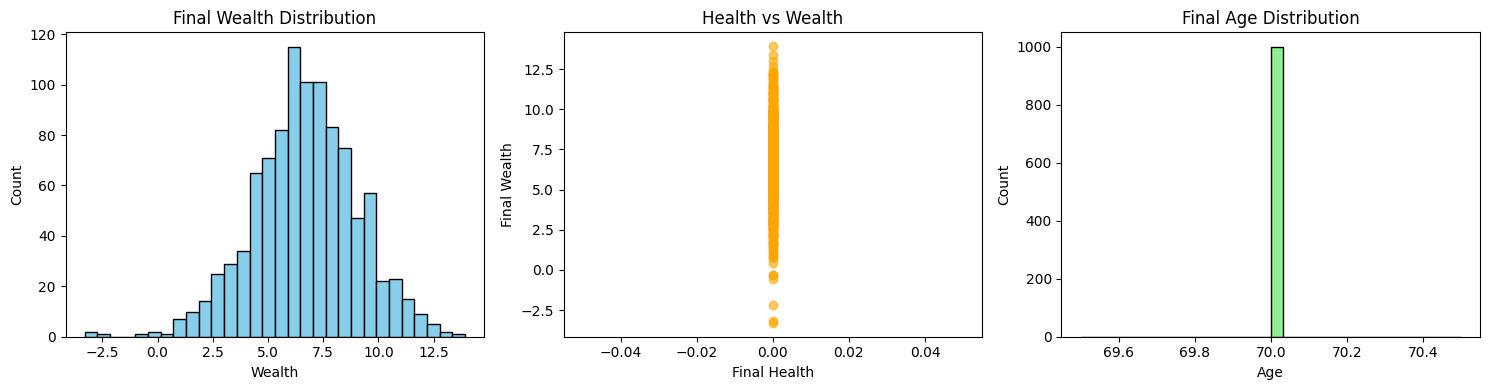

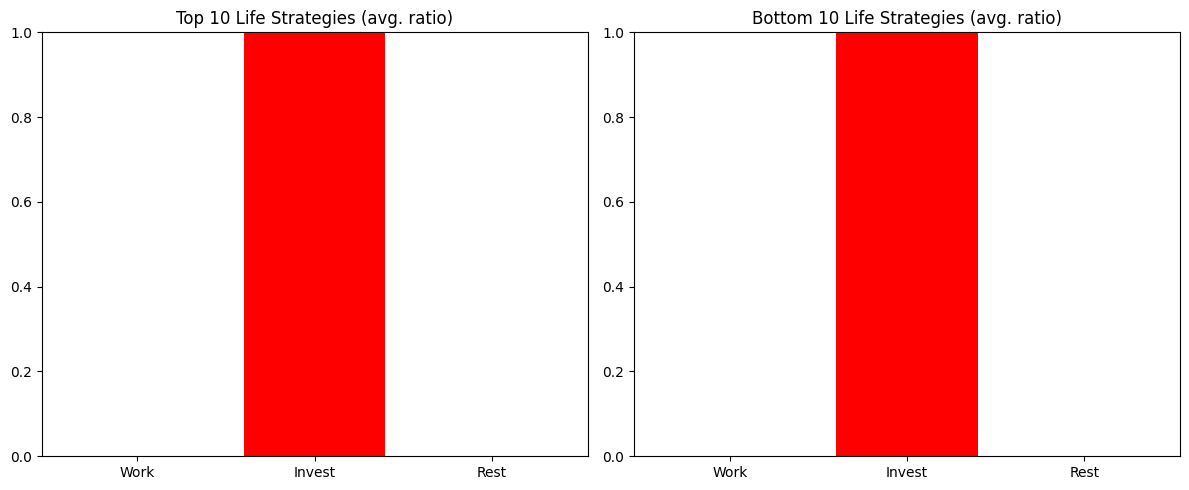


=== Top 10 Lives ===
     Episode  Total_Reward  Final_Wealth  Final_Health  Final_Age  Work_Count  \
0          0           8.0     13.925519           0.0       70.0           0   
385      385           8.0     13.344962           0.0       70.0           0   
60        60           7.2     12.363629           0.0       70.0           0   
100      100           7.2     12.154456           0.0       70.0           0   
151      151           7.2     12.677354           0.0       70.0           0   
566      566           7.2     13.028310           0.0       70.0           0   
604      604           7.2     12.014534           0.0       70.0           0   
14        14           6.8     11.552140           0.0       70.0           0   
17        17           6.8     11.997308           0.0       70.0           0   
29        29           6.8     11.006554           0.0       70.0           0   

     Invest_Count  Rest_Count  Work_Ratio  Invest_Ratio  Rest_Ratio  
0              5

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 读取前面保存的结果
df = pd.read_csv("lifesim_results_daily.csv")

# === 新增：计算行为比例 ===
df["Work_Ratio"] = df["Work_Count"] / (df["Work_Count"] + df["Invest_Count"] + df["Rest_Count"])
df["Invest_Ratio"] = df["Invest_Count"] / (df["Work_Count"] + df["Invest_Count"] + df["Rest_Count"])
df["Rest_Ratio"] = df["Rest_Count"] / (df["Work_Count"] + df["Invest_Count"] + df["Rest_Count"])

# 按奖励排序
top10 = df.nlargest(10, "Total_Reward")
bottom10 = df.nsmallest(10, "Total_Reward")

# === 原有三图 ===
plt.figure(figsize=(15, 4))

# 1. 财富分布
plt.subplot(1, 3, 1)
plt.hist(df["Final_Wealth"], bins=30, color="skyblue", edgecolor="black")
plt.title("Final Wealth Distribution")
plt.xlabel("Wealth")
plt.ylabel("Count")

# 2. 健康 vs 财富
plt.subplot(1, 3, 2)
plt.scatter(df["Final_Health"], df["Final_Wealth"], alpha=0.6, color="orange")
plt.title("Health vs Wealth")
plt.xlabel("Final Health")
plt.ylabel("Final Wealth")

# 3. 年龄分布
plt.subplot(1, 3, 3)
plt.hist(df["Final_Age"], bins=30, color="lightgreen", edgecolor="black")
plt.title("Final Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# === 新增：Top10 / Bottom10 行为比例对比 ===
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Top 10
axes[0].bar(["Work", "Invest", "Rest"],
            [top10["Work_Ratio"].mean(),
             top10["Invest_Ratio"].mean(),
             top10["Rest_Ratio"].mean()],
            color=["blue", "red", "green"])
axes[0].set_title("Top 10 Life Strategies (avg. ratio)")
axes[0].set_ylim(0, 1)

# Bottom 10
axes[1].bar(["Work", "Invest", "Rest"],
            [bottom10["Work_Ratio"].mean(),
             bottom10["Invest_Ratio"].mean(),
             bottom10["Rest_Ratio"].mean()],
            color=["blue", "red", "green"])
axes[1].set_title("Bottom 10 Life Strategies (avg. ratio)")
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# === 新增：打印详细表格 ===
print("\n=== Top 10 Lives ===")
print(top10[["Episode", "Total_Reward", "Final_Wealth", "Final_Health", "Final_Age",
             "Work_Count", "Invest_Count", "Rest_Count", "Work_Ratio", "Invest_Ratio", "Rest_Ratio"]])

print("\n=== Bottom 10 Lives ===")
print(bottom10[["Episode", "Total_Reward", "Final_Wealth", "Final_Health", "Final_Age",
                "Work_Count", "Invest_Count", "Rest_Count", "Work_Ratio", "Invest_Ratio", "Rest_Ratio"]])
